# 1. Import Install dependencies



In [1]:
%pip install tensorflow
%pip install tensorflow-io
%pip install tensorflow-gpu
%pip install pystan
%pip install fbprophet

     |████████████████████████████████| 462 kB 4.0 MB/s 
     |████████████████████████████████| 23.4 MB 3.7 MB/s 
     |████████████████████████████████| 511.7 MB 4.2 kB/s 
     |████████████████████████████████| 438 kB 55.8 MB/s 
     |████████████████████████████████| 1.6 MB 47.3 MB/s 
     |████████████████████████████████| 5.8 MB 52.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uni

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Dependencies
import os 
import math
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import date, datetime
import time

# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MAE, MSE, MAPE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

In [3]:
# Connect to Google drive 
from google.colab import drive
drive_path = os.path.join('/','content', 'drive')
folder_path = os.path.join(drive_path, 'MyDrive','Colab Notebooks')
data_path = os.path.join(drive_path , folder_path,'data','bitcoin' ,'btc.csv')
model_path = os.path.join( drive_path , folder_path,'models','BitCoinModel')

# Connect to drive 
drive.mount(drive_path)
print("drive path :\t "+drive_path)
print("folder path :\t "+folder_path)
print("data : \t\t "+data_path) 
print("model path :\t "+model_path)

Mounted at /content/drive
drive path :	 /content/drive
folder path :	 /content/drive/MyDrive/Colab Notebooks
data : 		 /content/drive/MyDrive/Colab Notebooks/data/bitcoin/btc.csv
model path :	 /content/drive/MyDrive/Colab Notebooks/models/BitCoinModel


# 2. Data Exploration

In [5]:
df = pd.read_csv("/content/drive/MyDrive/project/etc.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,13.9772,14.496100,13.8964,14.2095,14.2095,129201000
1,2017-11-10,14.1883,15.353500,13.9178,14.6031,14.6031,299856992
2,2017-11-11,14.6245,19.813299,14.5908,19.4209,19.4209,958982016
3,2017-11-12,19.4611,21.754101,15.0365,15.1837,15.1837,697452992
4,2017-11-13,15.3094,16.662600,14.4697,16.1059,16.1059,350880000


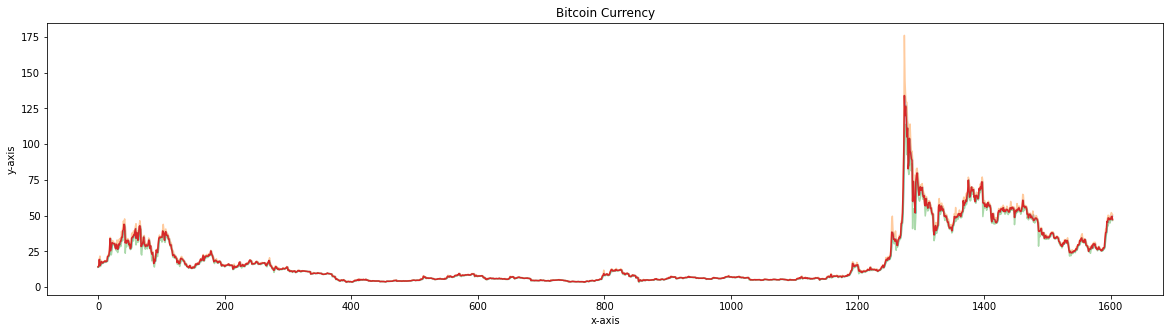

In [6]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['Open'], alpha=0.4)
ax.plot(df['High'], alpha=0.4)
ax.plot(df['Low'], alpha=0.4)
ax.plot(df['Close'])
ax.set(title='Bitcoin Currency', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency')

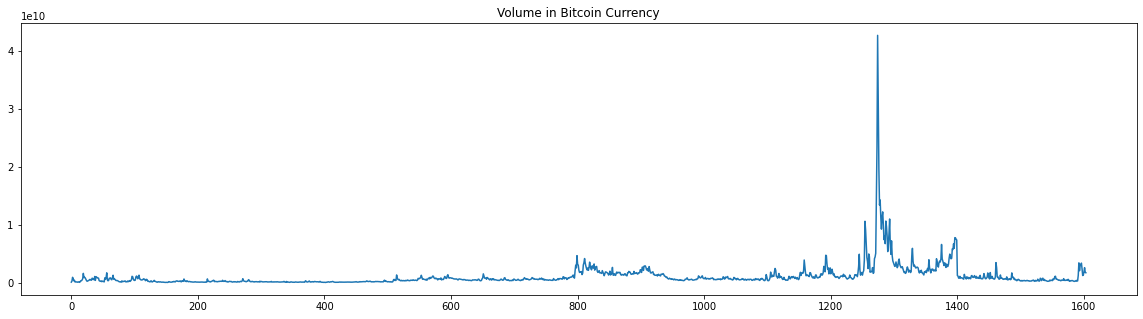

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['Volume']);
ax.set_title("Volume in Bitcoin Currency")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1604 non-null   object 
 1   Open       1604 non-null   float64
 2   High       1604 non-null   float64
 3   Low        1604 non-null   float64
 4   Close      1604 non-null   float64
 5   Adj Close  1604 non-null   float64
 6   Volume     1604 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.8+ KB


In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1604.000000,1604.000000,1604.000000,1604.000000,1604.000000,1.604000e+03
mean,18.735474,19.682998,17.771554,18.750129,18.750129,1.117932e+09
std,19.045344,20.462825,17.736973,19.049635,19.049635,2.068145e+09
min,3.475456,3.721599,3.304458,3.472387,3.472387,7.347600e+07
25%,5.760505,5.935070,5.581830,5.757764,5.757764,3.029265e+08
50%,9.410120,9.646175,9.090502,9.409617,9.409617,6.193583e+08
75%,27.447371,29.185083,26.091460,27.597798,27.597798,1.165105e+09
max,133.683578,176.157700,114.154610,134.101791,134.101791,4.272141e+10


# 3. Data Feature Engineering

In [10]:
# Convert date into numbers
# df['Year'] = df['Date'].apply(lambda x: int(str(x).split('-')[0]))
# df['Month'] = df['Date'].apply(lambda x: int(str(x).split('-')[1]))
# df['Day'] = df['Date'].apply(lambda x: int(str(x).split('-')[2]))


# Convert date to timestamp
# df['Date'] = df['Date'].apply(lambda x: time.mktime(datetime.strptime(x+" 22:24:46", '%Y-%m-%d %H:%M:%S').timetuple() ))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,13.9772,14.496100,13.8964,14.2095,14.2095,129201000
1,2017-11-10,14.1883,15.353500,13.9178,14.6031,14.6031,299856992
2,2017-11-11,14.6245,19.813299,14.5908,19.4209,19.4209,958982016
3,2017-11-12,19.4611,21.754101,15.0365,15.1837,15.1837,697452992
4,2017-11-13,15.3094,16.662600,14.4697,16.1059,16.1059,350880000


In [11]:
# Remove Adj Close
df = df.drop('Adj Close', axis=1)

In [12]:
# Removing Outliers from the data
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.10)
    Q3 = df.quantile(0.90)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(df[['Open','High','Low', 'Close','Volume']])

# Non-Outlier Subset of the Given Dataset
dfSubset = df[nonOutlierList]
dfSubset['Date'] = df['Date']
dfSubset.isnull().sum()

Date       0
Open       3
High       5
Low        1
Close      3
Volume    36
dtype: int64

In [13]:
# Removing Null values
dfSubset = dfSubset.dropna()

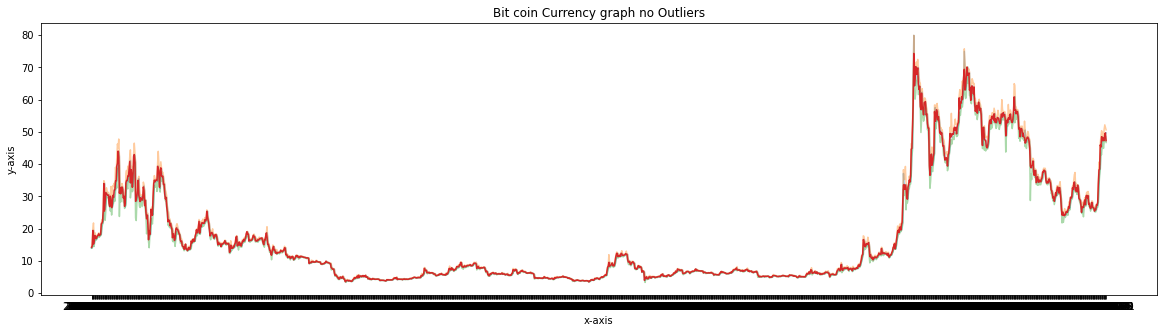

In [14]:
fig, ax = plt.subplots(figsize=(20,5))

date = dfSubset['Date']
ax.plot(date ,dfSubset['Open'], alpha=0.4)
ax.plot(date ,dfSubset['High'], alpha=0.4)
ax.plot(date ,dfSubset['Low'], alpha=0.4)
ax.plot(date ,dfSubset['Close'])

ax.set(title='Bit coin Currency graph no Outliers', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency No Outliers')

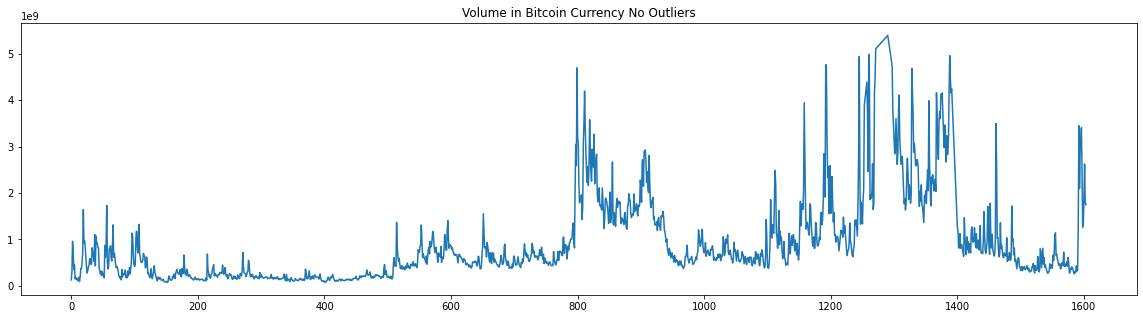

In [15]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(dfSubset['Volume']);
ax.set_title("Volume in Bitcoin Currency No Outliers")

In [16]:
# Expanding window statistics
future_forecast = 80

window = dfSubset.expanding() 
df_feat = dfSubset.copy()


WINDOWS = 7
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

    
# Rolling window 
df_feat['mov.Avg Open'] =   moving_average(dfSubset['Open'], WINDOWS)
df_feat['mov.Avg High'] = moving_average(dfSubset['High'], WINDOWS)
df_feat['mov.Avg Low'] = moving_average(dfSubset['Low'], WINDOWS)
df_feat['mov.Avg Close'] = moving_average(dfSubset['Close'], WINDOWS)
df_feat['mov.Avg Volume'] = moving_average(dfSubset['Volume'], WINDOWS)

df_feat.head()

,Date,Open,High,Low,Close,Volume,mov.Avg Open,mov.Avg High,mov.Avg Low,mov.Avg Close,mov.Avg Volume
0,2017-11-09,13.9772,14.496100,13.8964,14.2095,129201000.0,15.926057,17.819086,15.029357,16.419586,4.336683e+08
1,2017-11-10,14.1883,15.353500,13.9178,14.6031,299856992.0,16.429700,18.248600,15.384957,16.801185,4.413140e+08
2,2017-11-11,14.6245,19.813299,14.5908,19.4209,958982016.0,16.798900,18.566329,15.791286,17.178528,4.200426e+08
3,2017-11-12,19.4611,21.754101,15.0365,15.1837,697452992.0,17.168871,18.324600,16.135157,16.935328,3.058241e+08
4,2017-11-13,15.3094,16.662600,14.4697,16.1059,350880000.0,16.922271,17.798686,16.499014,17.325742,2.219906e+08


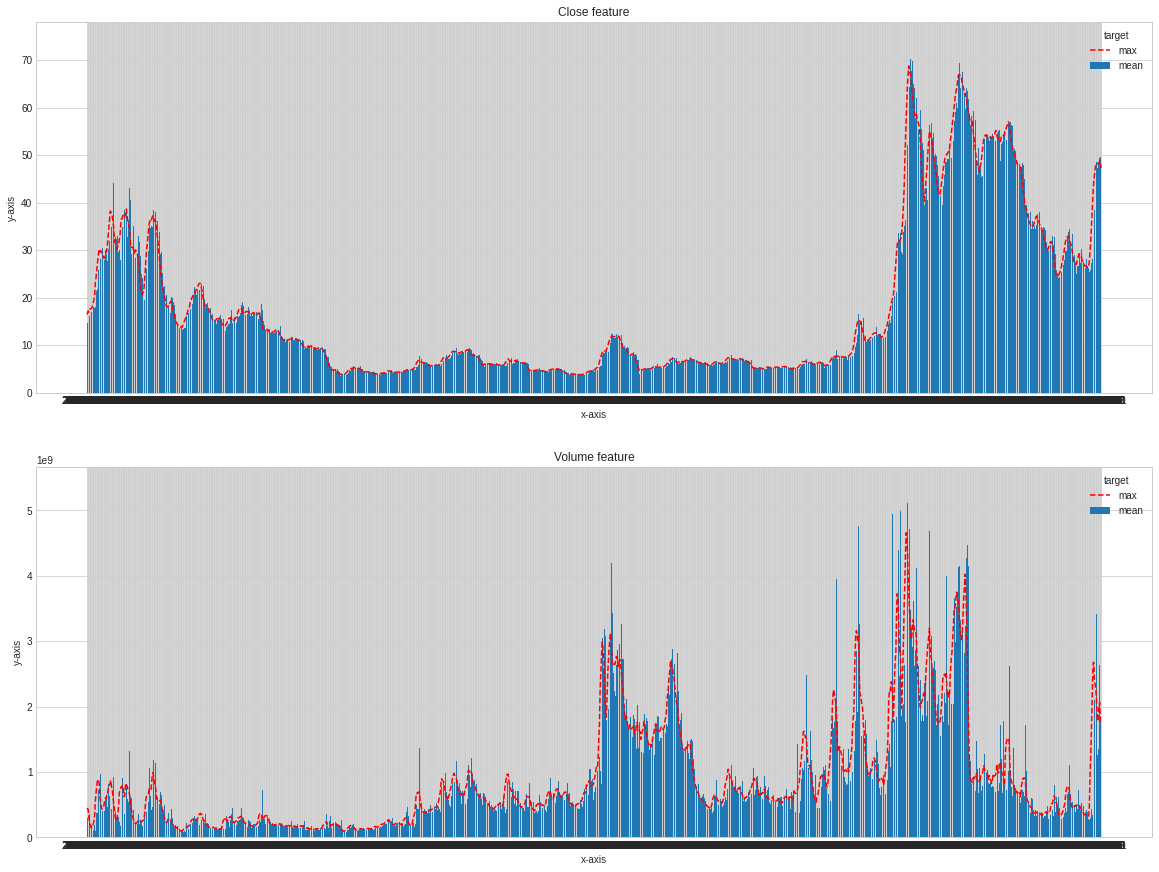

In [17]:
# Customizing the Y and X axis  
plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots( nrows=2, ncols=1, figsize=(20,15) )


ax0.bar(df_feat['Date'],df_feat['Close'])
ax0.plot(df_feat['Date'],df_feat['mov.Avg Close'], linestyle='--', color='red')
ax0.set(title='Close feature', xlabel='x-axis', ylabel='y-axis');
ax0.legend(['max', 'mean', 'Moving Average','Target'], title='target')


ax1.bar(df_feat['Date'],df_feat['Volume'], alpha=1,)
ax1.plot(df_feat['Date'],df_feat['mov.Avg Volume'], linestyle='--', color='red')
ax1.set(title='Volume feature', xlabel='x-axis', ylabel='y-axis');
ax1.legend(['max', 'mean', 'Moving Average','Target'], title='target')

# 4. Data Pre processing

In [18]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 0 to 1603
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1568 non-null   object 
 1   Open            1568 non-null   float64
 2   High            1568 non-null   float64
 3   Low             1568 non-null   float64
 4   Close           1568 non-null   float64
 5   Volume          1568 non-null   float64
 6   mov.Avg Open    1568 non-null   float64
 7   mov.Avg High    1568 non-null   float64
 8   mov.Avg Low     1568 non-null   float64
 9   mov.Avg Close   1568 non-null   float64
 10  mov.Avg Volume  1568 non-null   float64
dtypes: float64(10), object(1)
memory usage: 147.0+ KB


In [19]:
df_feat.head()

,Date,Open,High,Low,Close,Volume,mov.Avg Open,mov.Avg High,mov.Avg Low,mov.Avg Close,mov.Avg Volume
0,2017-11-09,13.9772,14.496100,13.8964,14.2095,129201000.0,15.926057,17.819086,15.029357,16.419586,4.336683e+08
1,2017-11-10,14.1883,15.353500,13.9178,14.6031,299856992.0,16.429700,18.248600,15.384957,16.801185,4.413140e+08
2,2017-11-11,14.6245,19.813299,14.5908,19.4209,958982016.0,16.798900,18.566329,15.791286,17.178528,4.200426e+08
3,2017-11-12,19.4611,21.754101,15.0365,15.1837,697452992.0,17.168871,18.324600,16.135157,16.935328,3.058241e+08
4,2017-11-13,15.3094,16.662600,14.4697,16.1059,350880000.0,16.922271,17.798686,16.499014,17.325742,2.219906e+08


In [20]:
# Select features (columns) to be involved intro training and predictions


predict_value = 'Close'      # Legend that we want to predict 

# Legends that support the legend we want to predict
cols = [
     'Open', 'High', 'Low', 'Volume', 'mov.Avg Open', 'mov.Avg High' ,'mov.Avg Volume','mov.Avg Close'
]

n_future = future_forecast        # Number of days we want top predict into the future
n_past =  40                      # Number of past days we want to use to predict the future
n_starting_date = df_feat['Date'][0]

# Generate columns 
cols.insert(0, predict_value)  

# Extract dates (will be used in visualization)
datelist_train = list(df_feat['Date'])
datelist_train = [datetime.strptime(date,'%Y-%m-%d').date() for date in datelist_train]


dates = df_feat['Date']
future_forcast = np.array([i for i in range(len(dates)+n_future )]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n_future ]
print('Training set shape == {}'.format(df_feat.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1568, 11)
All timestamps == 1568
Featured selected: ['Close', 'Open', 'High', 'Low', 'Volume', 'mov.Avg Open', 'mov.Avg High', 'mov.Avg Volume', 'mov.Avg Close']


In [21]:
dataset_train =  df_feat[cols].astype(str)
dataset_train = dataset_train.astype(float)


# Using multiple features (predictors)
training_set = dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))


Shape of training set == (1568, 9).


In [22]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1]).shape

(1568, 1)

In [23]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1449, 40, 8).
y_train shape == (1449, 1).


# 5. Creating LSTM Model

In [24]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(128,activation="sigmoid",input_shape=(n_past, dataset_train.shape[1]-1)) )

# Adding Dropout layer
model.add(Dropout(0.2))

 # Output layer
model.add(Dense(1))

# Compiling the Neural Network
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


# 6. Training and Validating the Model

In [25]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard('logs')

callbacks = [
    es,               
    rlr, 
    # mcp, 
    # tb
]
history = model.fit(X_train, y_train, shuffle=True, epochs=150, callbacks=callbacks, validation_split=0.2, verbose=1, batch_size=256)


Epoch 1/150
5/5 [==============================] - 3s 269ms/step - loss: 0.3243 - val_loss: 4.9777 - lr: 0.0010
Epoch 2/150
5/5 [==============================] - 1s 194ms/step - loss: 0.2510 - val_loss: 3.4246 - lr: 0.0010
Epoch 3/150
5/5 [==============================] - 1s 193ms/step - loss: 0.2348 - val_loss: 3.4577 - lr: 0.0010
Epoch 4/150
5/5 [==============================] - 1s 194ms/step - loss: 0.2215 - val_loss: 2.9699 - lr: 0.0010
Epoch 5/150
5/5 [==============================] - 1s 193ms/step - loss: 0.2040 - val_loss: 2.3723 - lr: 0.0010
Epoch 6/150
5/5 [==============================] - 1s 200ms/step - loss: 0.1970 - val_loss: 2.2594 - lr: 0.0010
Epoch 7/150
5/5 [==============================] - 1s 194ms/step - loss: 0.2004 - val_loss: 2.1200 - lr: 0.0010
Epoch 8/150
5/5 [==============================] - 1s 254ms/step - loss: 0.1926 - val_loss: 1.9067 - lr: 0.0010
Epoch 9/150
5/5 [==============================] - 2s 363ms/step - loss: 0.1891 - val_loss: 1.8591 - lr:

In [28]:
# model.save(os.path.join(folder_path,'models','BitCoinModel'))
model = tf.keras.models.load_model("/content/drive/MyDrive/project")

OSError: ignored

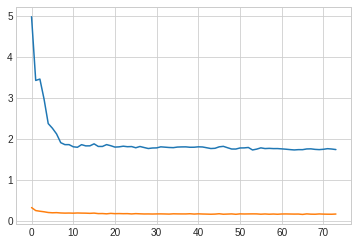

In [29]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

46/46 [==============================] - 2s 46ms/step


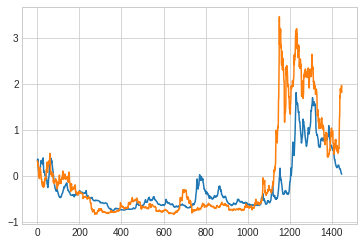

explained_variance:  0.5809
r2:  0.541
MAE:  0.3838
MSE:  0.4677
RMSE:  0.6839


In [30]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

y_pred = model.predict(X_train)
plt.plot(y_pred)
plt.plot(y_train)
plt.show()
regression_results(  y_train,y_pred)

# 6. Make future predictions

In [31]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())


In [32]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])


45/45 [==============================] - 1s 22ms/step


In [33]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[predict_value]).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[predict_value]).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.tail()

,Close
2022-03-27,18.575439
2022-03-28,18.373478
2022-03-29,18.048941
2022-03-30,17.934837
2022-03-31,17.947044


In [34]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)


dataset_train.set_index( pd.date_range(start=n_starting_date, periods=2748) , inplace=True)
dataset_train.tail()
 

ValueError: ignored

In [35]:
 PREDICTIONS_FUTURE.tail()

,Close
2022-06-14,18.575439
2022-06-15,18.373478
2022-06-16,18.048941
2022-06-17,17.934837
2022-06-18,17.947044


# 7. Visualzie Predictions

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


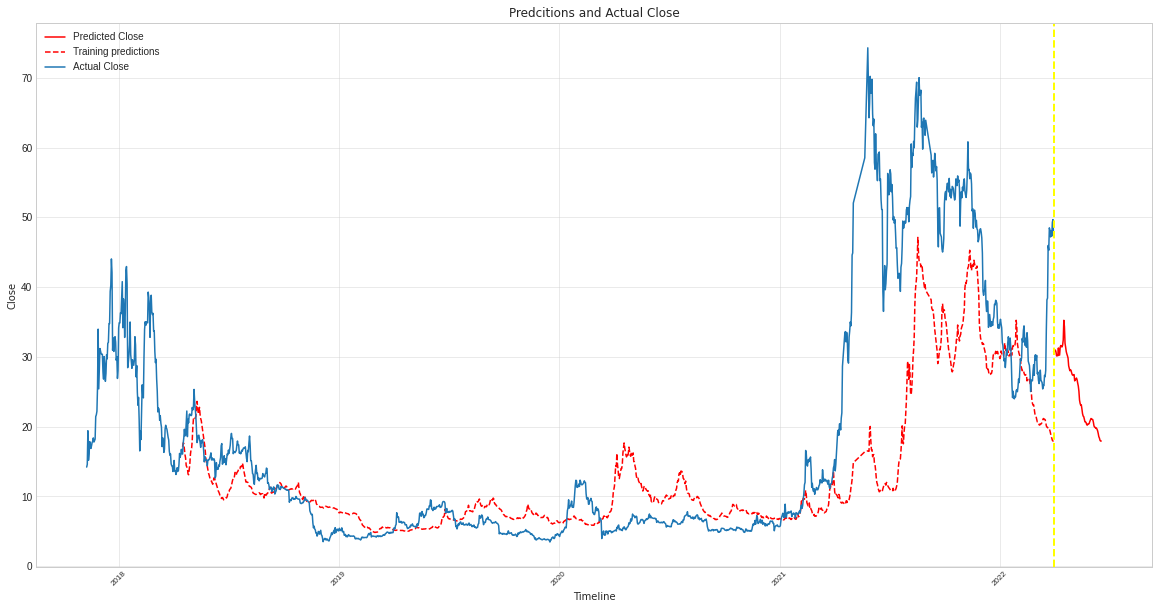

In [36]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.figure(figsize=(20, 10))


# Plot parameters
START_DATE_FOR_PLOTTING = n_starting_date
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='red', label='Predicted '+predict_value)
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][predict_value], color='red', label='Training predictions',linestyle='dashed')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][predict_value], label='Actual '+predict_value)

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='yellow', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual '+predict_value , family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel(predict_value, family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show();


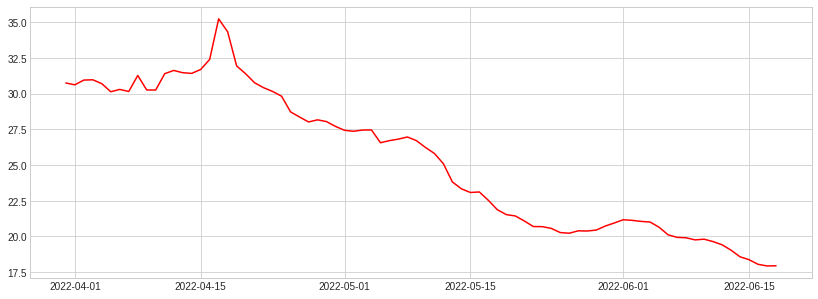

In [37]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='r', label='Predicted '+predict_value)
plt.show()

43/43 [==============================] - 1s 21ms/step


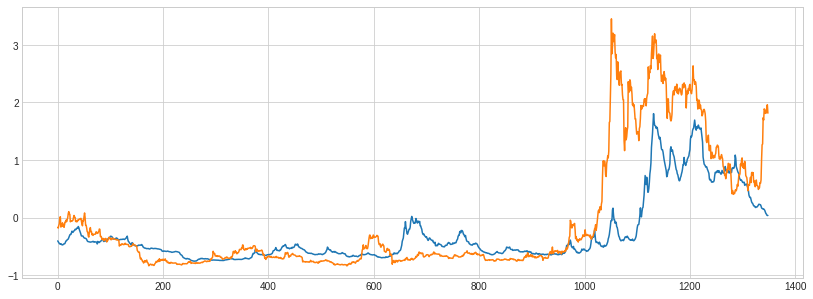

In [38]:
year_preds =  model.predict(X_train[100:])
plt.plot(year_preds) 
plt.plot(y_train[100:]) 